<a href="https://colab.research.google.com/github/wing787/books-python-satellite-data-analysis-basic/blob/main/3_ch3_3_Satellite_data_processing_with_GDAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 3-3　GDALを使った衛星データ処理
* 3-3-1： Landsat 8を観測データ加工方法
* 3-3-2: データ加工方法の背景
* 3-3-3: 画像の切り出し
* 3-3-4: カラー合成
* 3-3-5: パンシャープン画像の作成
* 3-3-6: フォーマットの変換

## GDALの使い方

In [ ]:
# Install GDAL
# !apt install gdal-bin python-gdal python3-gdal
# !apt install python3-rtree

In [ ]:
# Google Drive mount
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
from osgeo import gdal
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings

warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.dpi'] = 300  # 解像度

In [ ]:
# Setting LANDSAT-8 ファイル
fpath5 = '/content/drive/MyDrive/Colab Notebooks/Pythonで学ぶ衛星データ解析基礎-環境変化を定量的に把握しよう/data/3/3-3/LC08_L1TP_107035_20200429_20200820_02_T1_B5.TIF'

# Reading work to image by gdal.Open
band5_image = gdal.Open(fpath5)

# IR_Band_arrayという変数に、近赤外バンドの配列を入れる
NIR_Band_array = band5_image.ReadAsArray()

# plt.imshowで、配列を画像に表示
plt.imshow(NIR_Band_array);

In [ ]:
# Setting image size
plt.figure(figsize=(8, 8))

# Display "NIR_band_array" between 6,000 and 25,000
plt.imshow(NIR_Band_array, vmin=6000, vmax=25000, cmap='gray')

# Setting title
plt.title('NIR_Band', fontsize=18)

# Setting color bar
plt.colorbar()

plt.show();

In [ ]:
fpath2 = '/content/drive/MyDrive/Colab Notebooks/Pythonで学ぶ衛星データ解析基礎-環境変化を定量的に把握しよう/data/3/3-3/LC08_L1TP_107035_20200429_20200820_02_T1_B2.TIF'
fpath3 = '/content/drive/MyDrive/Colab Notebooks/Pythonで学ぶ衛星データ解析基礎-環境変化を定量的に把握しよう/data/3/3-3/LC08_L1TP_107035_20200429_20200820_02_T1_B3.TIF'
fpath4 = '/content/drive/MyDrive/Colab Notebooks/Pythonで学ぶ衛星データ解析基礎-環境変化を定量的に把握しよう/data/3/3-3/LC08_L1TP_107035_20200429_20200820_02_T1_B4.TIF'

band2_image = gdal.Open(fpath2)
band3_image = gdal.Open(fpath3)
band4_image = gdal.Open(fpath4)

BlueBand_array = band2_image.ReadAsArray()
GreenBand_array = band3_image.ReadAsArray()
RedBand_array = band4_image.ReadAsArray()

各バンドの分布範囲を確認

In [ ]:
plt.figure(figsize=(9, 4), tight_layout=True)

plt.subplot(3, 1, 1)
# Histgram of Blue band array
plt.hist(BlueBand_array.flatten(), bins=300, range=(5000, 20000))
plt.title('BlueBand', fontsize=10)

plt.subplot(3, 1, 2)
# Histgram of Green band array
plt.hist(GreenBand_array.flatten(), bins=300, range=(5000, 20000))
plt.title('GreenBand', fontsize=10)

plt.subplot(3, 1, 3)
# Histgram of Red band array
plt.hist(RedBand_array.flatten(), bins=300, range=(5000, 20000))
plt.title('RedBand', fontsize=10)


# output
plt.show();

In [ ]:
plt.figure(figsize=(9, 4), tight_layout=True)

# Output of Blue band
plt.subplot(1, 3, 1)
plt.imshow(BlueBand_array, vmin=8000, vmax=15000, cmap='Blues')
plt.title('BlueBand')

# Output of Green band
plt.subplot(1, 3, 2)
plt.imshow(GreenBand_array, vmin=7000, vmax=13000, cmap='Greens')
plt.title('BlueBand')

# Output of Red band
plt.subplot(1, 3, 3)
plt.imshow(RedBand_array, vmin=6000, vmax=14000, cmap='Reds')
plt.title('RedBand')

plt.show();

東京都の範囲で切り出し

In [ ]:
# 全体画像から、東京都の範囲で切り出し設定
minX=2700
minY=5100
deltaX=300
deltaY=300

# Set the name of the output image
cut_NIR_path = 'TOKYO_NIR.tif'

# gdal.Translate( [出力画像名], {入力画像名}, srcWin=[minX, minY, deltaX, deltaY])
ds = gdal.Translate(cut_NIR_path, fpath5, srcWin=[minX, minY, deltaX, deltaY])
ds = None

切り出した画像を表示

In [ ]:
# gdal.Openで画像を読み込み
cut_NIR_img = gdal.Open(cut_NIR_path)

# 画像情報を配列に変換
cut_NIR_array = cut_NIR_img.ReadAsArray()

# 表示パラメータを決めて、画像を表示
plt.figure(figsize=(8, 8))
plt.imshow(cut_NIR_array, vmin=6000, vmax=25000, cmap='Oranges')

plt.title('NIRBand(Tokyo)')
plt.colorbar()
plt.show();

画像のEPSGを確認

In [ ]:
band5_image = gdal.Open(fpath5)
# print("EPSG: " + gdal.Info(band5_image, format='json')['coordinateSystem']['wkt'].rsplit('"EPSG","', 1)[-1].split('"')[0])
print(gdal.Info(band5_image, format='json')['coordinateSystem']['wkt'])

# src_prj=band5_image.GetProjection()
# print (src_prj)

gdal.Warpを使用して座標系を変換(WGS 84 / UTM zone 54N → WGS84)

In [ ]:
latlon_band5_path = "latlon_band5_img.tif"

ds=gdal.Warp(latlon_band5_path,fpath5,srcSRS="EPSG:32654",dstSRS="EPSG:4326")
ds=None

In [ ]:
latlon_band5_img = gdal.Open(latlon_band5_path)
# print("EPSG: " + gdal.Info(latlon_band5_img, format = 'json')['coordinateSystem']['wkt'].rsplit('"EPSG","', 1)[-1].split('"')[0])
print(gdal.Info(latlon_band5_img, format='json')['coordinateSystem']['wkt'])

# src_prj=latlon_band5_img.GetProjection()
# print (src_prj)

In [ ]:
fpath4 = "/content/drive/MyDrive/Colab Notebooks/Pythonで学ぶ衛星データ解析基礎-環境変化を定量的に把握しよう/data/3/3-3/LC08_L1TP_107035_20200429_20200820_02_T1_B4.TIF"
fpath8 = "/content/drive/MyDrive/Colab Notebooks/Pythonで学ぶ衛星データ解析基礎-環境変化を定量的に把握しよう/data/3/3-3/LC08_L1TP_107035_20200429_20200820_02_T1_B8.TIF"

#緯度経度の情報を持ったバンド4と8のファイル名を定義
latlon_band4_path="latlon_band4_img.tif"
latlon_band8_path="latlon_band8_img.tif"

#gdal.Warpで座標系を変換
ds=gdal.Warp(latlon_band4_path,fpath4,srcSRS="EPSG:32654",dstSRS="EPSG:4326")
ds=gdal.Warp(latlon_band8_path,fpath8,srcSRS="EPSG:32654",dstSRS="EPSG:4326")
ds=None

In [ ]:
minX=139.7101
minY=35.6721
maxX=139.7201
maxY=35.6841

#切り出し後のファイルのファイル名を定義
cut_latlon_band4_path="cut_latlon_band4_img.tif"
cut_latlon_band8_path="cut_latlon_band8_img.tif"

#gdal.Translate で切り出しを実行
ds=gdal.Translate(cut_latlon_band4_path,latlon_band4_path, projWin=[minX,maxY,maxX,minY])
ds=gdal.Translate(cut_latlon_band8_path,latlon_band8_path, projWin=[minX,maxY,maxX,minY])
ds=None

In [ ]:
#それぞれgdal.Openで画像を読み込み
cut_latlon_band4_img=gdal.Open(cut_latlon_band4_path)
cut_latlon_band8_img=gdal.Open(cut_latlon_band8_path)

#それぞれ配列情報を読み込み
cutRedBand_array   = cut_latlon_band4_img.ReadAsArray()
cutPanBand_array   = cut_latlon_band8_img.ReadAsArray()

#画像を表示
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(cutRedBand_array,vmin=6000,vmax=12000,cmap='gray')
plt.title("RedBand")

plt.subplot(1,2,2)
plt.imshow(cutPanBand_array,vmin=5000,vmax=15000,cmap='gray')
plt.title("PanchroBand")


plt.show();

In [ ]:
fpath2 = "/content/drive/MyDrive/Colab Notebooks/Pythonで学ぶ衛星データ解析基礎-環境変化を定量的に把握しよう/data/3/3-3/LC08_L1TP_107035_20200429_20200820_02_T1_B2.TIF"
fpath3 = "/content/drive/MyDrive/Colab Notebooks/Pythonで学ぶ衛星データ解析基礎-環境変化を定量的に把握しよう/data/3/3-3/LC08_L1TP_107035_20200429_20200820_02_T1_B3.TIF"
fpath4 = "/content/drive/MyDrive/Colab Notebooks/Pythonで学ぶ衛星データ解析基礎-環境変化を定量的に把握しよう/data/3/3-3/LC08_L1TP_107035_20200429_20200820_02_T1_B4.TIF"
fpath5=  "/content/drive/MyDrive/Colab Notebooks/Pythonで学ぶ衛星データ解析基礎-環境変化を定量的に把握しよう/data/3/3-3/LC08_L1TP_107035_20200429_20200820_02_T1_B5.TIF"

#8bit出力データ名を指定しておく
band5_8bit_path="Band5_8bit.tif"
band4_8bit_path="Band4_8bit.tif"
band3_8bit_path="Band3_8bit.tif"
band2_8bit_path="Band2_8bit.tif"

#切り出しの詳細
minX=2400
minY=4500
deltaX=1500
deltaY=1500

#各バンドのファイルを、それぞれ、関心領域のみ切り出す。出力は8bitのgeotifとする
#gdal.Translate({出力画像名}, {入力画像名}, outputType={データ形式設定} , scaleParams=[[min,max]])
#
gdal.Translate(band2_8bit_path,fpath2,outputType=gdal.GDT_Byte,scaleParams=[[9700,13400]],srcWin=[minX,minY,deltaX,deltaY]  )
gdal.Translate(band3_8bit_path,fpath3,outputType=gdal.GDT_Byte,scaleParams=[[8100,12800]], srcWin=[minX,minY,deltaX,deltaY] )
gdal.Translate(band4_8bit_path,fpath4,outputType=gdal.GDT_Byte,scaleParams=[[7000,13000]],srcWin=[minX,minY,deltaX,deltaY] )
gdal.Translate(band5_8bit_path,fpath5,outputType=gdal.GDT_Byte,scaleParams=[[6000,18300]],srcWin=[minX,minY,deltaX,deltaY] )

#作成した8bitの切り出し画像を読み込む
b2_image=gdal.Open(band2_8bit_path)
b3_image=gdal.Open(band3_8bit_path)
b4_image=gdal.Open(band4_8bit_path)
b5_image=gdal.Open(band5_8bit_path)

#読み込んだ画像を配列に変換する
BlueBand_array  = b2_image.ReadAsArray()
GreenBand_array = b3_image.ReadAsArray()
RedBand_array   = b4_image.ReadAsArray()
NIRBand_array   = b5_image.ReadAsArray()

In [ ]:
#出力ファイルの設定のために、入力ファイルのX方向のピクセル数、Y方向のピクセル数を読み出す
Xsize=b2_image.RasterXSize #band2の画像のX方向ピクセル数
Ysize=b2_image.RasterYSize #band2の画像のY方向ピクセル数
dtype=gdal.GDT_Byte
band=3

#出力ファイルの設定を行う(True Color)
out_True_path ="TrueColor_TOKYO.tif"    #出力ファイル名

#空の出力ファイルを作成する
out1= gdal.GetDriverByName('GTiff').Create(out_True_path, Xsize, Ysize, band, dtype)#({出力ファイル名}, {X方向のピクセル数},{Y方向のピクセル数},{バンド数},{データ形式})

#出力ファイルの座標系を設定する
out1.SetProjection(b2_image.GetProjection())      #{出力変数}.SetProjection(座標系情報)
out1.SetGeoTransform(b2_image.GetGeoTransform())  #{出力変数}.SetGeoTransform(座標に関する６つの数字)

#Red、Green、Blueバンドの配列を、WriteArrayを用いて出力ファイルの3バンドに書き込む
out1.GetRasterBand(1).WriteArray(RedBand_array)   #赤の配列を赤バンドに書き込む
out1.GetRasterBand(2).WriteArray(GreenBand_array) #緑の配列を緑バンドに書き込む
out1.GetRasterBand(3).WriteArray(BlueBand_array)  #青の配列を青バンドに書き込む
out1.FlushCache()

In [ ]:
plt.figure(figsize=(8,8))

image1 = mpimg.imread(out_True_path)
plt.imshow(image1)
plt.title("True Color TOKYO")

plt.show();

In [ ]:
####出力ファイルの設定を行う(False Color)
#出力ファイルの設定
out_False_path="FalseColor_TOKYO.tif"

out2= gdal.GetDriverByName('GTiff').Create(out_False_path, Xsize, Ysize, band, dtype)
out2.SetProjection(b2_image.GetProjection())
out2.SetGeoTransform(b2_image.GetGeoTransform())

#Red、Green、Blueバンドの配列を、出力ファイルの3バンドに書き出す
out2.GetRasterBand(1).WriteArray(NIRBand_array)  #近赤外の配列を赤バンドに書き込む
out2.GetRasterBand(2).WriteArray(RedBand_array)  #赤の配列を緑バンドに書き込む
out2.GetRasterBand(3).WriteArray(GreenBand_array)#緑の配列を青バンドに書き込む
out2.FlushCache()

####出力ファイルの設定を行う(Natural Color)
#出力ファイルの設定
out_Natural_path="NaturalColor_TOKYO.tif"

out3= gdal.GetDriverByName('GTiff').Create(out_Natural_path, Xsize, Ysize, band, dtype)
out3.SetProjection(b2_image.GetProjection())
out3.SetGeoTransform(b2_image.GetGeoTransform())

#Red、Green、Blueバンドの配列を、出力ファイルの3バンドに書き出す
out3.GetRasterBand(1).WriteArray(RedBand_array)  #赤の配列を赤バンドに書き込む
out3.GetRasterBand(2).WriteArray(NIRBand_array)  #近赤外の配列を緑バンドに書き込む
out3.GetRasterBand(3).WriteArray(GreenBand_array)#緑の配列を青バンドに書き込む
out3.FlushCache()

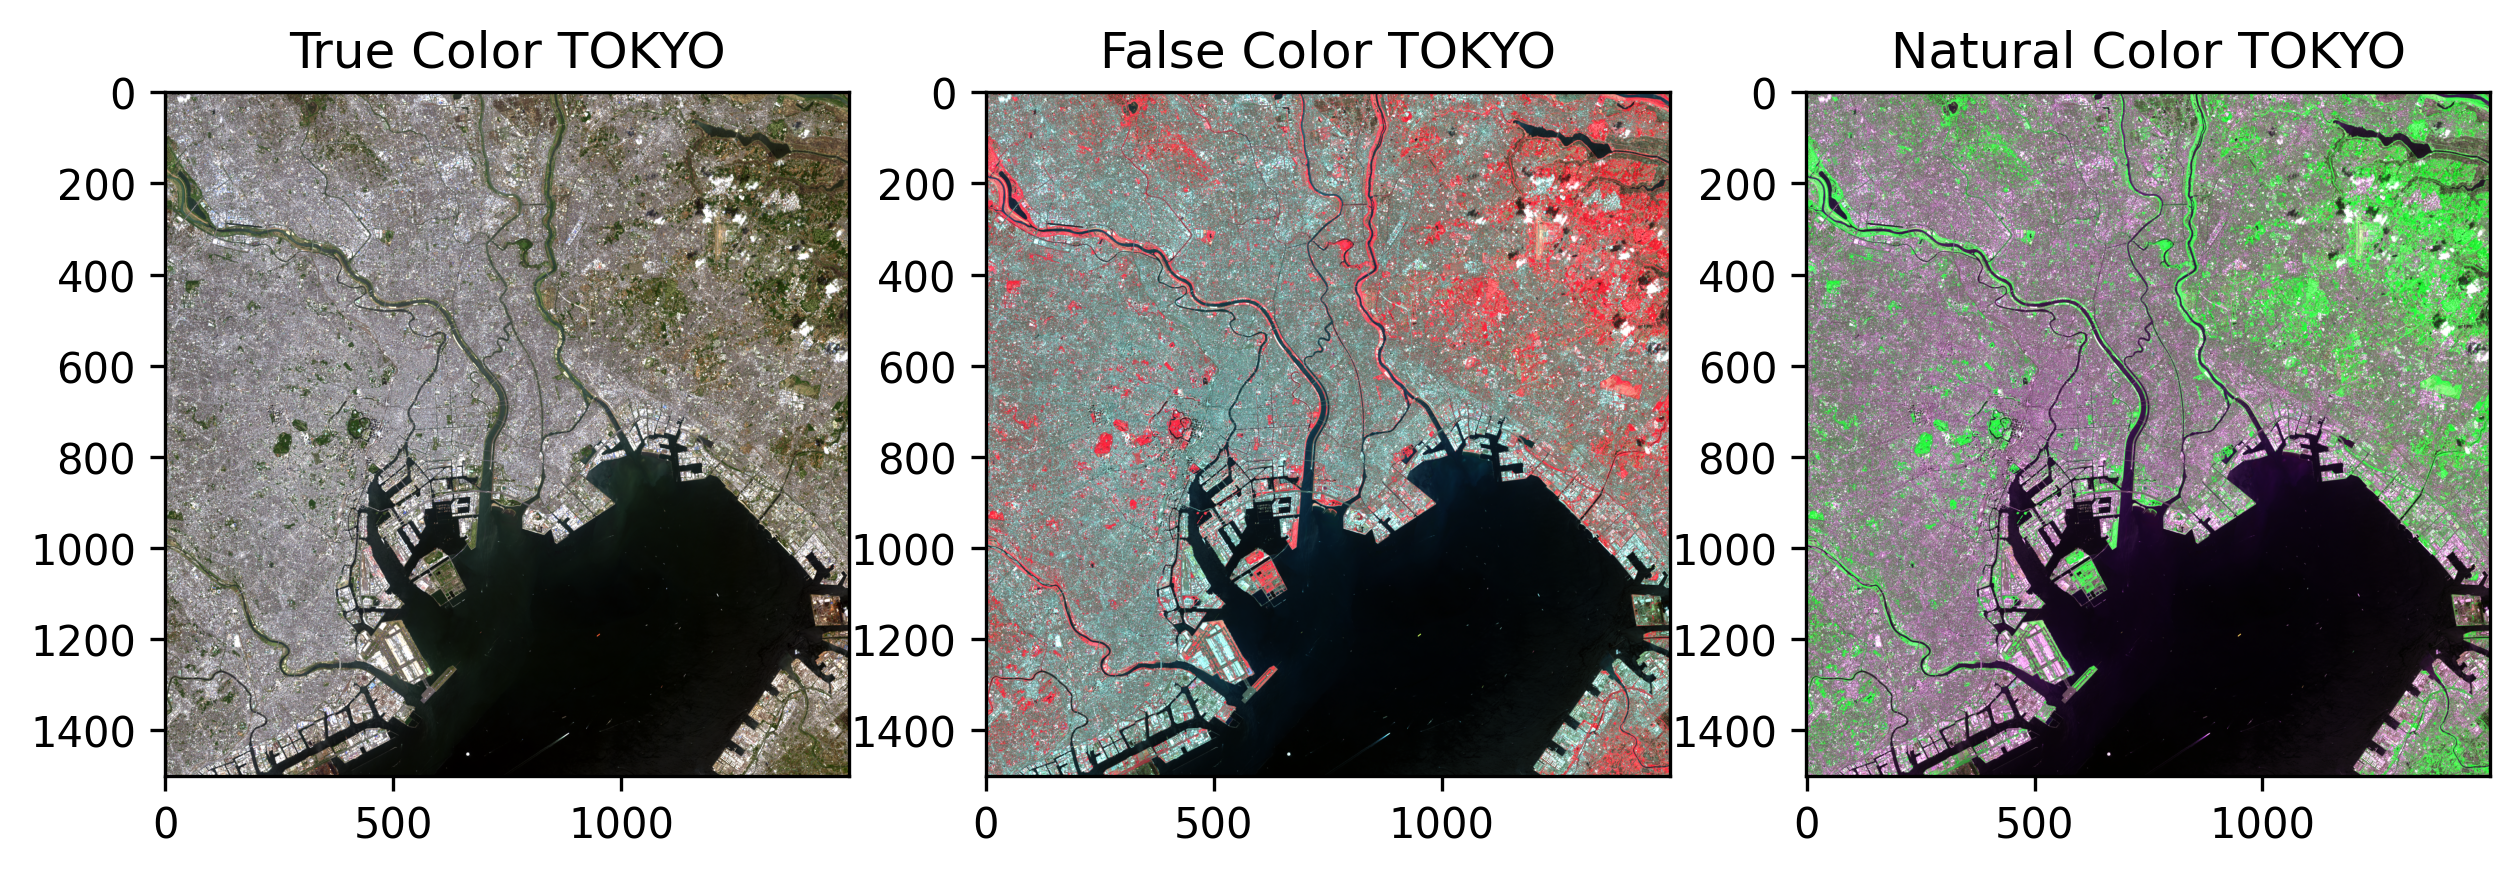

In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
image1 = mpimg.imread(out_True_path)
plt.imshow(image1)
plt.title("True Color TOKYO")

plt.subplot(1,3,2)
image2 = mpimg.imread(out_False_path)
plt.imshow(image2)
plt.title("False Color TOKYO")

plt.subplot(1,3,3)
image3 = mpimg.imread(out_Natural_path)
plt.imshow(image3)
plt.title("Natural Color TOKYO")

plt.show();

# パンシャープン画像の作成

In [ ]:
!which gdal_pansharpen.py

/usr/local/bin/gdal_pansharpen.py


In [ ]:
# import sys
# sys.path.append('/usr/bin/')
from osgeo_utils.gdal_pansharpen import *

In [ ]:
fpath8 = "/content/drive/MyDrive/Colab Notebooks/Pythonで学ぶ衛星データ解析基礎-環境変化を定量的に把握しよう/data/3/3-3/LC08_L1TP_107035_20200429_20200820_02_T1_B8.TIF"

band8_8bit_path="Band8_8bit.tif"

#切り出しの詳細（ここでは、マルチカラーの2倍を指定することで同じ場所を切り出すことが可能）
minX=4800
minY=9000
deltaX=3000
deltaY=3000

ds=gdal.Translate(band8_8bit_path,fpath8,outputType=gdal.GDT_Byte,scaleParams=[[5000,15000]],srcWin=[minX,minY,deltaX,deltaY] )
ds=None

In [ ]:
#パンシャープン画像のファイル名を指定します。
pansharpen_path="PANSHARPEN.tif"

#ds=gdal_pansharpen(["",band8_8bit_path,out_Natural_path,pansharpen_path])
ds=gdal_pansharpen(["",band8_8bit_path, band4_8bit_path, band3_8bit_path,band2_8bit_path, pansharpen_path])
ds=None

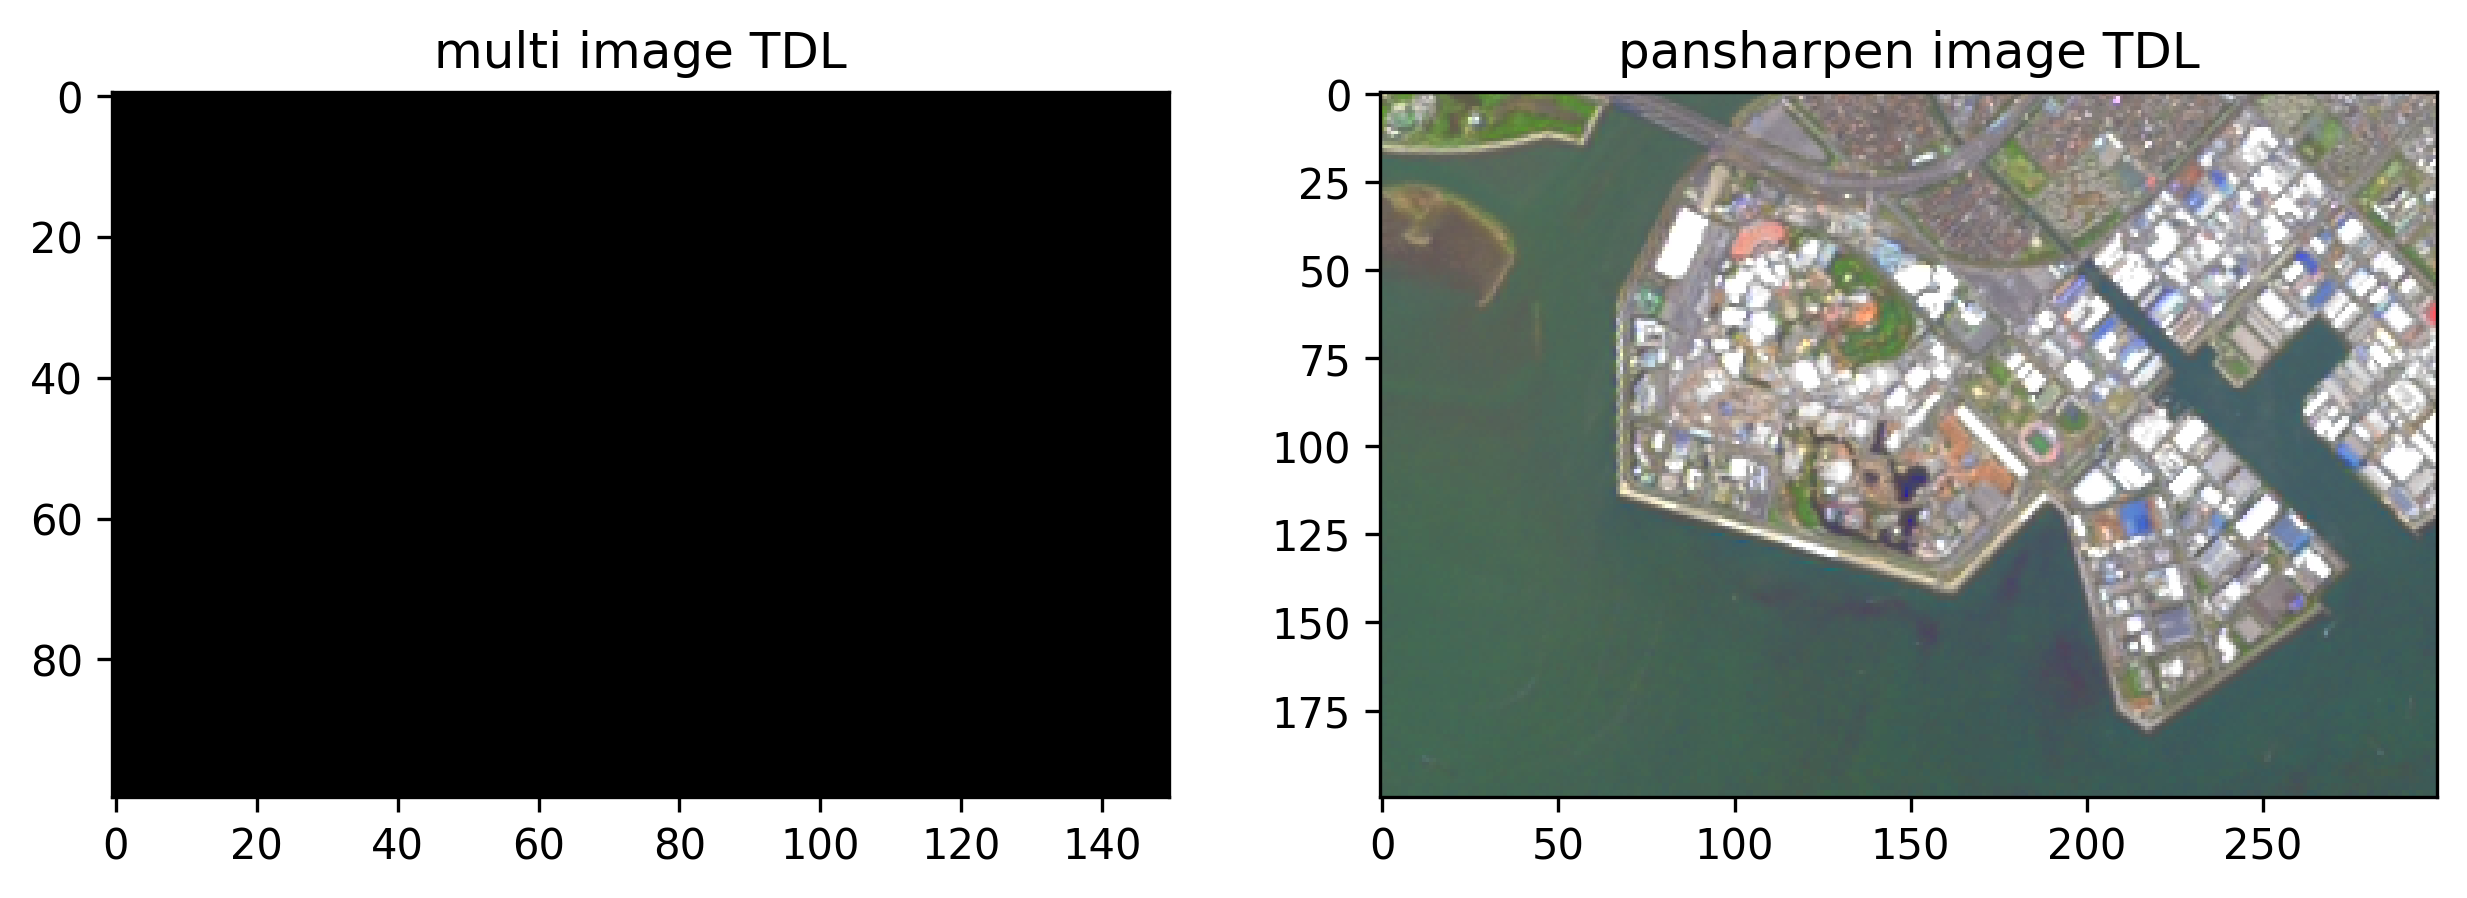

In [ ]:
#パンシャープン用切り出しの詳細
minX=1500
minY=1800
deltaX=300
deltaY=200

cut_pans="cut_pans.tif"

ds=gdal.Translate(cut_pans,pansharpen_path,srcWin=[minX,minY,deltaX,deltaY]  )
ds=None

#マルチ画像用切り出しの詳細
minX2=750
minY2=900
deltaX2=150
deltaY2=100

cut_RGB="cut_RGB.tif"

#ds=gdal.Translate(cut_RGB,out_True_path,srcWin=[minX2,minY2,deltaX2,deltaY2]  )
ds=gdal.Translate(cut_RGB,out_True_path,srcWin=[minX2,minY2,deltaX2,deltaY2])
ds=None

#画像の表示
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
image1 = mpimg.imread(cut_RGB)
plt.imshow(image1)
plt.title("multi image TDL")

plt.subplot(1,2,2)
image2 = mpimg.imread(cut_pans)
plt.imshow(image2)
plt.title("pansharpen image TDL")

plt.show();

In [ ]:
PNG_img_path="Pansharpen.png"  #出力のファイル名を定義

gdal.Translate(
    PNG_img_path,   #出力画像名
    cut_pans, #入力画像名
    format='PNG'#出力ファイルのフォーマット指定
    )

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7b1d722e73f0> >

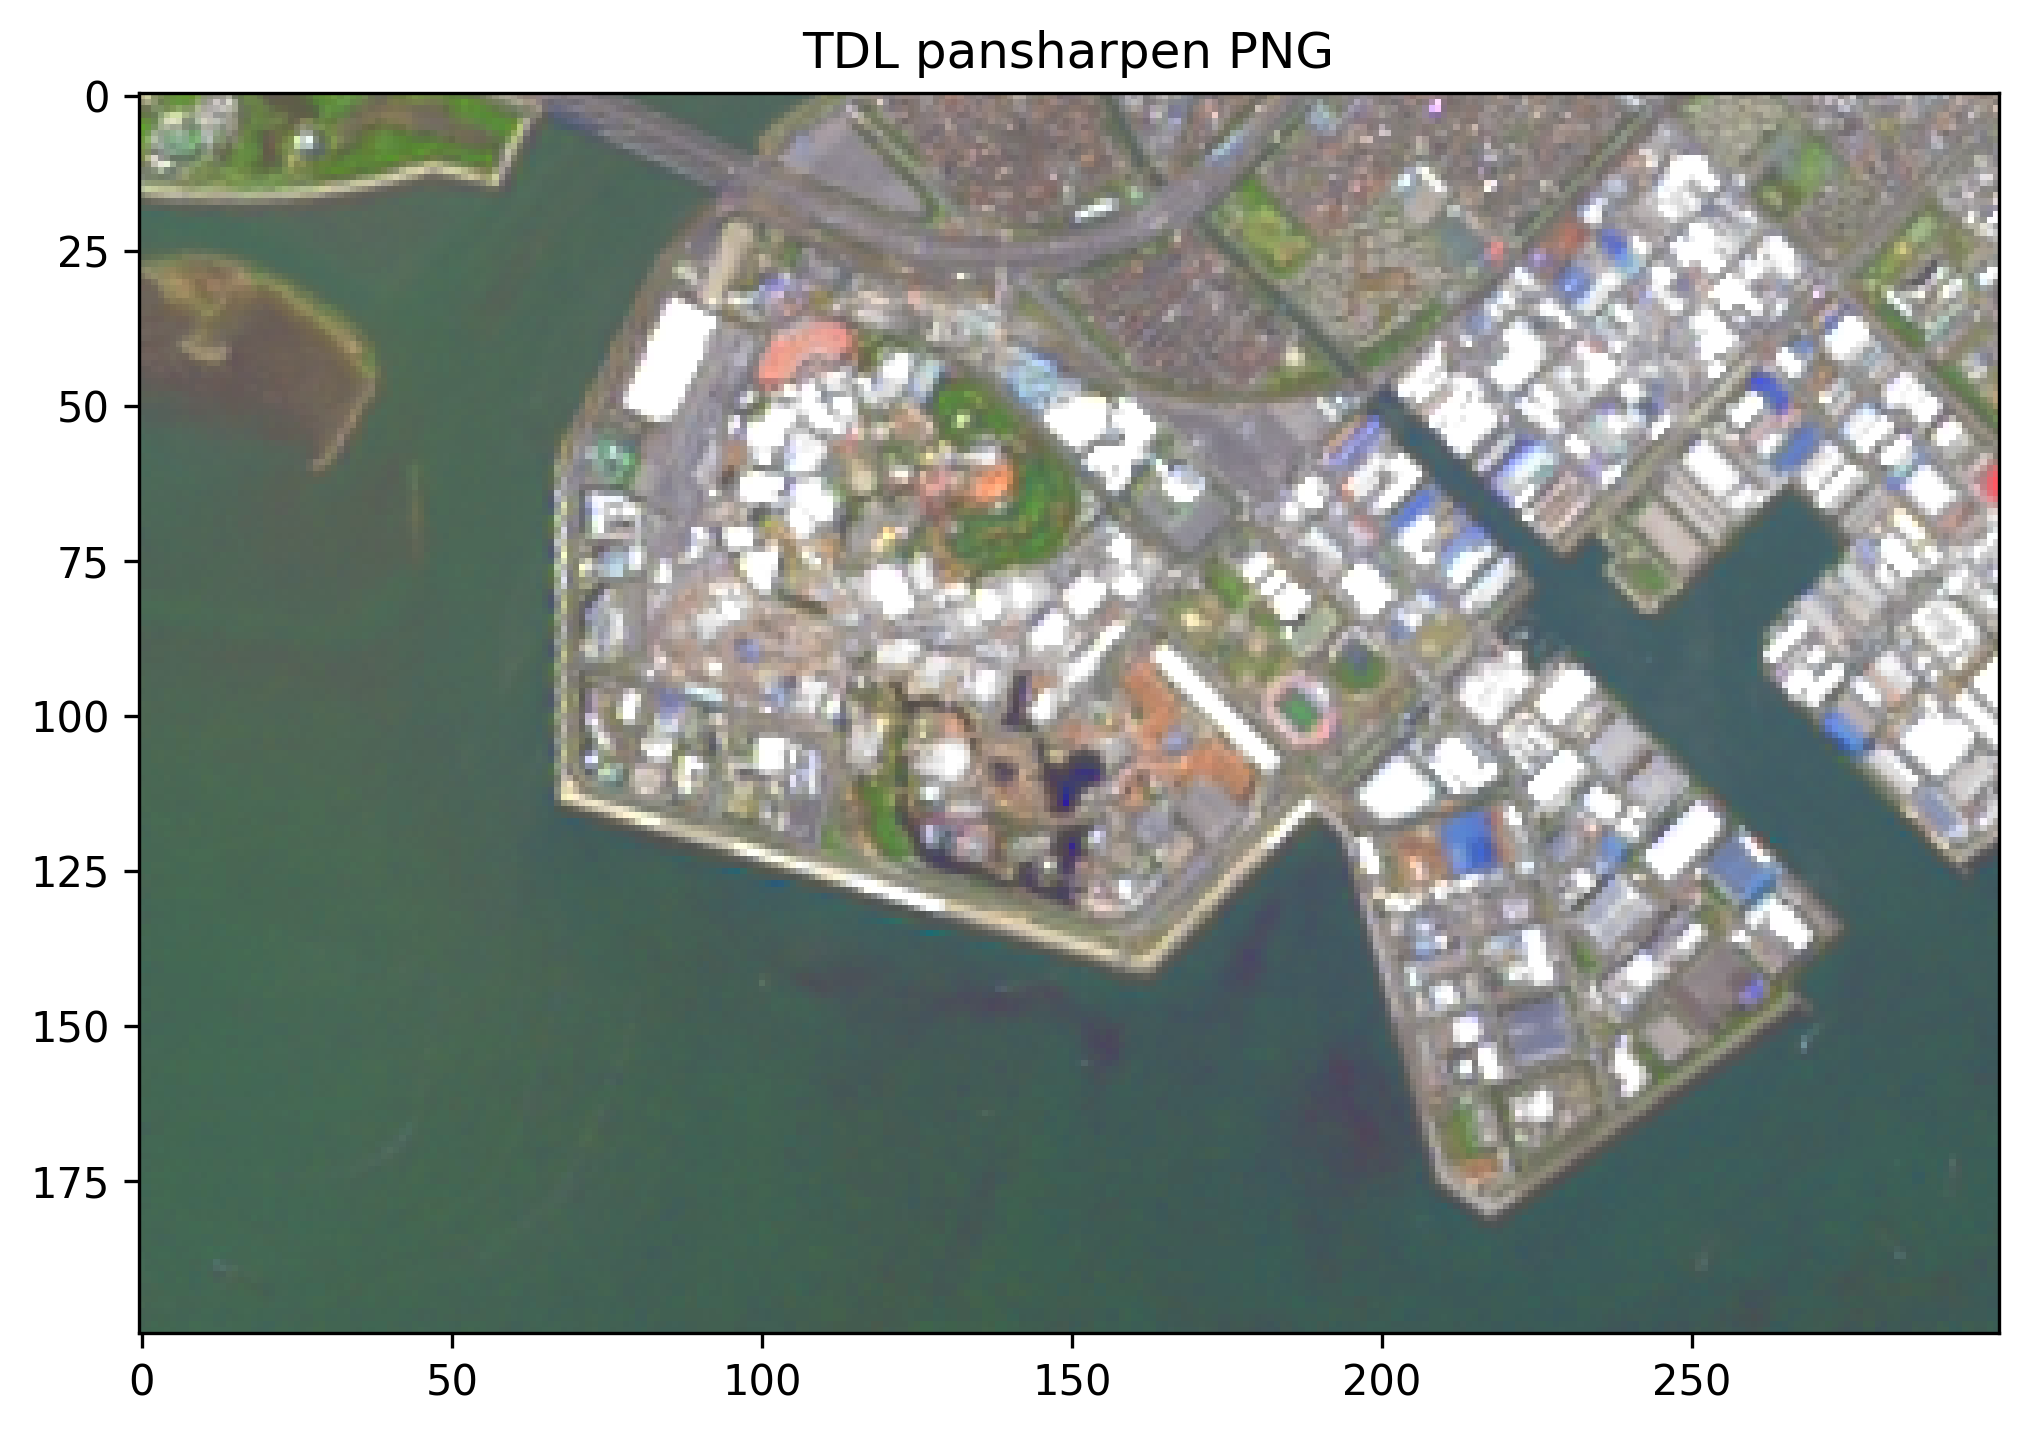

In [ ]:
plt.figure(figsize=(8,8))

PNGimg= mpimg.imread(PNG_img_path)
plt.imshow(PNGimg)

plt.title("TDL pansharpen PNG")
plt.show();

gdal_mergeを用いたコンポジット画像の作成を行う

In [ ]:
!which gdal_merge.py

/usr/local/bin/gdal_merge.py


In [ ]:
from osgeo_utils import gdal_merge

In [ ]:
fpath2 = "/content/drive/MyDrive/Colab Notebooks/Pythonで学ぶ衛星データ解析基礎-環境変化を定量的に把握しよう/data/3/3-3/LC08_L1TP_107035_20200429_20200820_02_T1_B2.TIF"
fpath3 = "/content/drive/MyDrive/Colab Notebooks/Pythonで学ぶ衛星データ解析基礎-環境変化を定量的に把握しよう/data/3/3-3/LC08_L1TP_107035_20200429_20200820_02_T1_B3.TIF"
fpath4 = "/content/drive/MyDrive/Colab Notebooks/Pythonで学ぶ衛星データ解析基礎-環境変化を定量的に把握しよう/data/3/3-3/LC08_L1TP_107035_20200429_20200820_02_T1_B4.TIF"

# 出力画像の名前を指定
Blue_path_8bit = '8bitTOKYO_Blue.tif'
Green_path_8bit = '8bitTOKYO_Green.tif'
Red_path_8bit = '8bitTOKYO_Red.tif'

# gdal.translate( {出力画像名}, {入力画像名}, srcWin=[minX, minY, deltaX, deltaY] )
ds = gdal.Translate(Blue_path_8bit, fpath2, outputType = gdal.GDT_Byte, scaleParams=[[9700, 13400]])
ds = gdal.Translate(Green_path_8bit, fpath3, outputType = gdal.GDT_Byte, scaleParams=[[8100, 12800]])
ds = gdal.Translate(Red_path_8bit, fpath4, outputType = gdal.GDT_Byte, scaleParams=[[7000, 13000]])
ds = None

In [ ]:
gdal_merge.main(["", "-o", "RGB_KANTO2.tif", "-separate", Red_path_8bit, Green_path_8bit, Blue_path_8bit])

In [ ]:
plt.figure(figsize=(8, 8))

img = mpimg.imread("RGB_KANTO2.tif")
plt.imshow(img)

plt.title("KANTO")
plt.show();